In [223]:
%reload_ext autoreload
%autoreload 2

import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.

plotly.offline.init_notebook_mode(connected=True)
cm = sns.light_palette("green", as_cmap=True)

from tqdm import tqdm

import os
import sys
import re
import gc
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

import tensorflow as tf

from umap import UMAP
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, MiniBatchDictionaryLearning as DL, NMF, FastICA as ICA 
from sklearn.decomposition import FactorAnalysis as FA, SparsePCA as SPCA

from omic_helpers import omic_helpers as hlp


from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.svm import SVC

from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, HuberRegressor, ARDRegression
from pygam import GAM, LinearGAM, ExpectileGAM, s, f, l, te
from ngboost import NGBRegressor as ngbr
from ngboost.distns import LogNormal, Normal,Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from pyearth import Earth
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from interpret import show as eb_show

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from shap import TreeExplainer, force_plot, dependence_plot, summary_plot, KernelExplainer, LinearExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import AffinityPropagation

from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

from sklearn.feature_selection import mutual_info_classif as Minfo, f_classif as Fval, chi2
from scipy.stats import ks_2samp as ks, wasserstein_distance as wass

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import MaxPooling1D
from keras.callbacks import Callback
from keras.layers.convolutional import Conv1D
from keras.layers import Input 

In [224]:
def simple_1dcnn(dims=None, conv_layers=[(32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1)], init_dropout=0.55, final_dropout=0.55):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, 1)))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Conv1D(filters=_l[0], kernel_size=_l[1], strides=_l[3]))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=_l[2]))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(final_dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_loss])
    
    return model

def simple_dnn(dims=None, conv_layers=[(128,0.05), (64,0.05), (48,0.05), (32,0.1)], init_dropout=0.25, final_dropout=0.5):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, )))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Dense(_l[0], activation='relu'))
        model.add(Dropout(_l[1]))
        
    model.add(Dropout(final_dropout))    
    model.add(Dense(1,  activation='sigmoid'))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', dice_loss])     # 'binary_crossentropy'     
    return model

@jit
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    xmean =  (xs[1:] + xs[:-1])/2
    xdiff = xs[1:] - xs[:-1]
    H = -np.sum(rhos*np.log(rhos+eps)*xdiff)
    Hr = H/np.sum(xdiff)
    return Hr

def expander(x, y=None, fun=None):
    '''
        x : np array 
        fun : expansion function, assumes pairwise expansion
    '''
    if y is None:
        num_rows, num_cols = x.shape[0], x.shape[1]
        _num_cols = np.int((num_cols**2-num_cols)/2)
        xex = np.zeros(shape=(num_rows, _num_cols)) 
        k=0
        for jl in range(0, num_cols):
            for jr in range(jl+1, num_cols):                
                xex[:, k] =   fun(x[:,jl], x[:,jr])
                k +=1
    else:
        num_rows_l, num_rows_r, num_cols_l, num_cols_r = x.shape[0], y.shape[0], x.shape[1], y.shape[1]
        _num_cols = np.int(num_cols_l*num_cols_r)
        xex = np.zeros(shape=(num_rows_l, _num_cols))
        k=0
        for jl in range(0, num_cols_l):
            for jr in range(0, num_cols_r):               
                xex[:, k] =   fun(x[:,jl], y[:,jr])
                k +=1
    return xex

   


In [225]:
pre_filter = True # filter out weak univariates for classification
x_transform = StandardScaler() # MinMaxScaler, QuantileTransformer
x_reducer = None # PCA(n_components=10)
rem_coll = True
outlier_replacer = True

In [226]:
# Load gene list
genes = pd.read_csv('../../_meta_data/gene_types/selected_genes.csv', sep='\t')
genes.Symbol = genes.Symbol.str.upper()

In [227]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

We start with RNA expression, methylation and DNA mutations separately.

The differentiation targets are the treatment response, the cancer types and the tissue type.

We use :

* statistical difference
* geometric difference
* multivariate classification

# Load data

In [228]:
# RNA 
# Methylation
# mutation
# Load meta data: immunoresponse, age, gender

dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

miRNA = pd.read_csv('Lung_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv("Lung_Proteome.txt", sep="\t")
proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [229]:
granzyms = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('(GZM)|(SECT)|(PRF)')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'granzyms'} for _int in granzyms])
genes = pd.concat([genes, tmp])

In [230]:
interferons = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('IFN')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'interferon'} for _int in interferons])
genes = pd.concat([genes, tmp])

In [231]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)

meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))

In [232]:
dd['RNAex'].Gene = dd['RNAex'].Gene.str.upper()
RNAex = dd['RNAex'].to_pandas_df()
RNAex = RNAex.loc[RNAex.Gene.isin(genes.Symbol)]
RNAex.sort_values(by='Gene', inplace=True)
RNAex.Start = RNAex.Start.astype(str)
RNAex.Stop = RNAex.Stop.astype(str)
RNAex['rnaID'] = RNAex[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
rnamap = RNAex[['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
RNAex.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
RNAex = RNAex.set_index('rnaID').transpose()
gc.collect()

81145

In [233]:
low_var_list = RNAex.loc[:, rnamap['rnaID']].columns[RNAex.loc[:, rnamap['rnaID']].var()==0.].tolist()
rnaID_include = list(set(rnamap.rnaID) - set(low_var_list))
cols = rnaID_include

In [234]:
dd['mutation'].Gene = dd['mutation'].Gene.str.upper()
mutation = dd['mutation'].to_pandas_df()
mutation = mutation.loc[mutation.Gene.isin(genes.Symbol)]
mutation.set_index('Sample_ID', inplace=True)
gc.collect()

5

In [235]:
dd['methylation'].Gene = dd['methylation'].Gene.str.upper()
methylation = dd['methylation'].to_pandas_df()
methylation = methylation.loc[methylation.Gene.isin(genes.Symbol)]
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
probemap.reset_index(drop=True, inplace=True)
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1, inplace=True)
methylation = methylation.set_index('probeID').transpose()
gc.collect()

5

In [236]:
methylation_meta = dd['methylation_meta'].to_pandas_df()
methylation_meta = methylation_meta.loc[methylation_meta.IlmnID.isin(methylation.columns)]
gc.collect()

0

In [237]:
dd['CNV'].Gene = dd['CNV'].Gene.str.upper()
CNV = dd['CNV'].to_pandas_df()
CNV = CNV.loc[CNV.Gene.isin(genes.Symbol)]
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Start.fillna("nan", inplace=True)
CNV.Stop.fillna("nan", inplace=True)
CNV.Strand.fillna("nan", inplace=True)
CNV.Chr.fillna("nan", inplace=True)
CNV['cnvID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
cnvmap = CNV[['cnvID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
cnvmap.reset_index(drop=True, inplace=True)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV = CNV.set_index('cnvID').transpose()
gc.collect()

5

In [238]:
# deal with with multicollinearity
# 1. replace collinear cliques
# 2. only keep exemplar features

In [239]:
RNAex = RNAex.join(meta[meta_cols])

In [240]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets
red = 'UMAP'
reduceR = UMAP(n_components=3, random_state=323, n_neighbors=50) #UMAP(n_components=3)
reduceR.fit(RNAex.loc[:, rnaID_include])


fig = go.Figure(layout={'title': 'RNA expression:'+red+' components'})
# Configure the trace.
reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                                      (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Adenocarcinoma, primary tumor'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                      (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Squamous Cell Carcinoma, primary tumor'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                                      (RNAex['Sample Type']=='Solid Tissue Normal'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Adenocarcinoma, normal tissue'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                      (RNAex['Sample Type']=='Solid Tissue Normal'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Squamous Cell Carcinoma, normal tissue'
)
)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
plotly.offline.iplot(fig)

The UMAP visualisation suggest that the cancer types are **clearly** separable using RNA expression data. 

In [241]:
# 3 class problem: LA+primary tumor, LSCC+primary tumor, normal tissue
def make_target(x):
    if (x[0]=='Lung Squamous Cell Carcinoma') and (x[1]=='Primary Tumor'):
        return 'LSCC-tumor'
    elif (x[0]=='Lung Adenocarcinoma') and (x[1]=='Primary Tumor'):
        return 'LA-tumor'
    elif (x[1]=='Solid Tissue Normal'):
        return 'normal-tissue'
        
RNAex['y'] = RNAex[['Diagnosis', 'Sample Type']].apply(lambda x: make_target(x), axis=1)

In [242]:
Xmother = RNAex.dropna(subset=['y'])
X = Xmother.loc[:, rnaID_include].values
Y = Xmother['y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

### Filter out non-informative features

Ingredients:
* KS-score: ```ks_scores(X,y)```.
* Wasserstein distance: ```wass1_scores(X,y)```.
* quantile entropy: N-quantiles, average target value per quantile, with/without threshold

#### Entropy of pdf

To remove low-variant features is actually to remove low entropy features. As the idea of low variance is completely dependent on the scaling of the feature low entropy will give a 
more robust feature filter. For continuous variables we have to use *differential entropy*, described as; 
$$H = - \int \rho(x) \ln \rho(x) dx $$

The best we can do is to approximate this using the histograms of the features;

$$H \approx - \sum \rho(b_i) \ln \rho(b_i) \Delta x_i$$

where $b_i$ represent the bins. To bound it between zero and one we should write

$$H \approx - \frac{\sum \rho(b_i) \ln \rho(b_i) \Delta x_i}{\sum \Delta x_i}$$

which is implemented in ```diff_entropy_scores(X)```.

Note that the correct differential entropy is actually written as 
$$H = - \int \rho(x) \ln \frac{\rho(x)}{m(x)} dx $$

where $m(x)$ is the invariant measure.


#### Entropy of ordered target vector
If we order the target vector by the continuous values of the feature vector and subsequently
reward successive target values and penalize differing target values we get the following ansatz for the series entropy
$$\frac{1}{2^{N+1-2C}} \prod^N_{i=1} \delta_{i,i-1}\, 2^{\delta_{i,i-1}} + (1-\delta_{i,i-1})\,2^{\delta_{i,i-1}-1}$$

where $\delta_{i,j}=0$ if $y_i\neq y_j$ and $\delta_{i,j}=1$ if $y_i= y_j$.

If we do not penalize disorder and only reward order we get the following
$$\frac{1}{2^{N+1-2C}} \prod^N_{i=1}  2^{\delta_{i,i-1}}= 2^{\left[\sum \delta_{i,i-1}\right]-(N+1-2C)}$$.

Which is intractable due to the $2^{-(N+1-2C)}$ term an approximation is given by
$$\frac{1}{N+1-2C}\sum^N_{i=1} \delta_{i,i-1}\label{eq1}\tag{1}$$
with $\delta_{i,j}=-1$ if $y_i\neq y_j$. Equation \ref{eq1} is implemented in the function
```seq_entropy_scores(X,y)```.

The benefit of this approach is that there is no dependency on monotonous/linear relationships between the 
feature values and the target value. A down side is that there is no relationship with the actual feature value, other than the order.

One way to obtain information about larger sequence lengths without using recursion is the application of binning. Suppose we have a binomial problem with $Q$ bins we get the following recursion ansatz
$$\prod^Q_{i=1} \frac{1}{\Delta c_{max}}\left\vert \overline{c}_i-c_r\right\vert\label{eq2}\tag{2}$$
where $c_r$ is the a priori class ratio and $\overline{c}_i$ is the class ratio for bin $i$, where
$\Delta c_{max}=\max{\left(1-c_r,c_r\right)}$. We might apply a sliding window/rolling bin to avoid discontinuities. The downside of \ref{eq2} is that it is exactly zero if only one bin has exactly the same target mean as the overall target vector. An easy fix is to change the product to a sum
$$\frac{1}{Q \, \Delta c_{max}}\sum^Q_{i=1}\left\vert \overline{c}_i-c_r\right\vert\label{eq3}\tag{3}$$

Equations  \ref{eq2} and \ref{eq3} are implemented in ```qseq_entropy_scores(X,y)``` with the 
function parameter ```q_type``` is ```prod```and ```sum```respectively.

To improve we might want to involve the actual probability that a sequence of target values belongs to 
a group of a certain length $g$. This involves the binomial distribution, where

$$Pr(X=k) = \left(\begin{array}{c} n \\ k \end{array}\right) p^k(1-p)^{n-k}$$

where $$\left(\begin{array}{c} n \\ k \end{array}\right) = \frac{n!}{k!(n-k)!},$$

this represents the probability that we have a set of $k$ successes (value $1$ in our case) in $n$ trials, given some prior probability $p$. However, this description is not tractable due to the huge requirement on the number accuracy. Rather, we take samples from the binomial distribution to approximate this number, with ```sum(np.random.binomial(k, p, num_samples)==1)/num_samples```.
#### Entropy change of quantiles 

We extract $N$ quantiles for the parts of the feature vector associated with the different target values, 
this gives $C$ vectors of size $N$ representing the different quantiles. For each quantile we can extract descriptive information. Firstly we are interesting in the degree entropy change between the quantiles, we express this in 
* Kullback-Leibler divergence
* Shannon entropy change
* Cross-entropy

This functionality is implemented in the function ```ec_scores(X,y, num_bins=10)``` with the function parameter ```ent_type``` being ```kl```, ```shannon``` or ```cross```.


#### Entropy of ordered target vector with different sequence lengths

We order the target array by the feature vector values and subsequently extract the occurrences
of varying sequence lengths. We attribute a different probability to each sequence length and we combine these in a combined unprobability. A high unprobability implies a high non-randomness in the target vector ordering and vice versa. 

We use a convolution operation to approximately count the number of target sequences, we perform
a weighted sum of these counts, where the weights are given by the probability mass function of the binomial distribution. 


Implemented in ```seqX_entropy_scores(X,Y)```.

#### Cumulative distribution differences 

EMD, CvM


### Model based

Accuracy scores relative to the base accuracy by just applying a quantile split.

$$D_{qmod} = \frac{score_{k}}{c_r}$$

Implemented in ```medacc_scores(X,y)```.

### Variance based

Change in variance relative to overall variance. We define the variance score as
$$D_{var} = \Delta \sigma^2/\overline{\sigma}$$
where the $\Delta$ represents the difference over the two class vectors.

Implemented in ```var_dist(X,y)```.

### Delta of quantiles

Change of quantile values relative to standard deviation.

$$D_{quantile}= \frac{\Delta q_k}{\min{\left(\sigma_0, \sigma_1\right)}}$$

Implemented in ```q_dists(X,y,q=0.5)```.

### Chi2 of quantile binned target vectors

Implemented in ```chi2_scores(X,y, bins)```.


In [333]:
stat_dist_df = hlp.get_statdist_dataframe_binomial(X,Y, features=rnaID_include)

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITH looplifting enabled because Function "diff_entropy_scores" failed type inference due to: Invalid use of Function(<class 'type'>) with argument(s) of type(s): (array(float64, 2d, F))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<class 'type'>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (191)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 191:
def diff_entropy_scores(X, eps=1e-6, bins=20):
    if "DataFrame" in str(type(X)):
    ^

INFO:MainThread:numba.transforms:finding looplift ca


Compilation is falling back to object mode WITH looplifting enabled because Function "wass1_scores" failed type inference due to: Untyped global name 'wass': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 571:
def wass1_scores(X,y):
    <source elided>
    for jdx in range(0, scores.shape[0]):
        scores[jdx] = wass(X[np.argwhere(y==0)[:,0], jdx], 
        ^

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITHOUT looplifting enabled because Function "wass1_scores" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 570:
def wass1_scores(X,y):
    <source elided>
    scores = np.zeros((X.shape[1],))
    for jdx in range(0, scores.shape[0]):
    ^

Functi


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ks_scores" failed type inference due to: Untyped global name 'ks': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 556:
def ks_scores(X,y):
    <source elided>
    for jdx in range(0, scores.shape[0]):
        scores[jdx,:] = ks(X[np.argwhere(y==0)[:,0], jdx], 
        ^

Function "ks_scores" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 555:
def ks_scores(X,y):
    <source elided>
    scores = np.zeros((X.shape[1], 2))
    for jdx in range(0, scores.shape[0]):
    ^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/refe


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qseq_entropy_scores" failed type inference due to: Invalid use of type(CPUDispatcher(<function qseq_entropy at 0x7f2b15d74d08>)) with parameters (array(int64, 1d, C), bins=int64, q_type=unicode_type)
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function qseq_entropy at 0x7f2b15d74d08>))
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (413)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 413:
def qseq_entropy_scores(X, y, q_type='sum', bins=20):
    <source elided>
        y_sorted = y[np.argsort(X[:, jdx])]
        scores[jdx] = qseq_entropy(y_sorted, q_type=q_type, bins=bins)
        ^

Function "qseq_entropy_scores" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hac

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITHOUT looplifting enabled because Function "seqX_entropy_scores" failed type inference due to: Invalid use of type(CPUDispatcher(<function get_seq_entropyX at 0x7f2afe06f7b8>)) with parameters (array(int64, 1d, C), array(int64, 1d, C), array(float64, 2d, C))
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function get_seq_entropyX at 0x7f2afe06f7b8>))
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (481)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 481:
def seqX_entropy_scores(X, y, seqrange=(2, 20)):
    <source elided>
        xa = X[:, jdx]
        scores[jdx] = get_seq_entropyX(y[np.argsort(xa)], seqnums, factors)
        ^

Function "seqX_entropy_scores" was compiled in object mode without forceo


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_cdf" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 262:
def _cdf(x, bin_size=5):
    <source elided>
    res, _res = np.empty((0, 2)), np.empty((0, 2))
    for i in range(bin_size, c):
    ^

Function "_cdf" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 259:
def _cdf(x, bin_size=5):
    x = np.sort(x)
    ^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

Fil


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cdf_scoresG" failed type inference due to: Untyped global name '_cdf_distanceG': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 317:
def cdf_scoresG(X, y, dist_type="emd"):
    <source elided>
    for jdx in range(0, scores.shape[0]):
        scores[jdx] = _cdf_distanceG(X[np.argwhere(y==0)[:,0], jdx],
        ^

Function "cdf_scoresG" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 316:
def cdf_scoresG(X, y, dist_type="emd"):
    <source elided>
    scores = np.zeros((X.shape[1],))
    for jdx in range(0, scores.shape[0]):
    ^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more 


Compilation is falling back to object mode WITH looplifting enabled because Function "q_acc_scores" failed type inference due to: Invalid use of Function(<function amax at 0x7f2cc8452d90>) with argument(s) of type(s): (list(float64))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function amax at 0x7f2cc8452d90>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (219)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 219:
def q_acc_scores(X,y, q=0.5):
    qp = np.max([0.5-q, q])
    ^

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITHOUT lo

Function "_information_change" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 597:
@jit
def _information_change(v1, v2, ent_type = 'kl', bin_type='fixed', num_bins=10):
^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 597:
@jit
def _information_change(v1, v2, ent_type = 'kl', bin_type='fixed', num_bins=10):
^

divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in su

invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in cos
invalid value encountered in sin
invalid value encountered in multiply
invalid value encountered in cos
invalid value encountered in sin


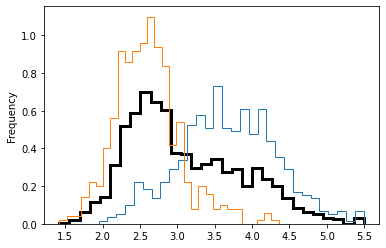

In [410]:
tgene = 'DLG1_chr3_197042560_197299300_-'
RNAex.loc[:, tgene].plot.hist(bins=30, histtype='step', color='black', lw=3, density=True)
RNAex.loc[RNAex.y=='LSCC-tumor', tgene].plot.hist(bins=30, histtype='step', density=True)
#RNAex.loc[RNAex.y=='normal-tissue', 'CEACAM6_chr19_41750977_41772208_+'].plot.hist(bins=30, histtype='step')
RNAex.loc[RNAex.y=='LA-tumor', tgene].plot.hist(bins=30, histtype='step', density=True)

In [112]:
if outlier_replacer:
    X = hlp.featurewise_outlier_replacer(X, q=(0.01, 0.99))


Compilation is falling back to object mode WITH looplifting enabled because Function "featurewise_outlier_replacer" failed type inference due to: Invalid use of Function(<class 'type'>) with argument(s) of type(s): (array(float64, 2d, F))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<class 'type'>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (163)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 163:
def _cdfcoeff(x, bin_size=5):
    <source elided>
    diff1 = np.diff(lt[:, 1]) * lt[:-1, 0]
    diff1[0:1] = 0
    ^

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation i

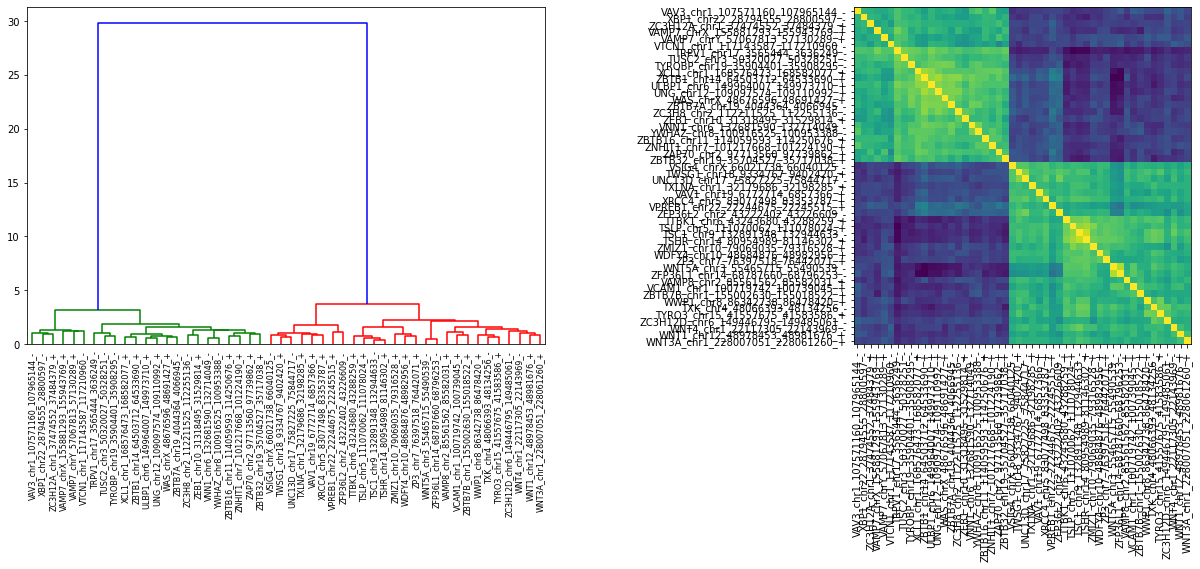

Number of exemplars: 20


In [128]:
# filter by
if pre_filter:
    include = stat_dist_df.sort_values(by='seqentropyX_wass1', ascending=False)[:50].index
    X = Xmother.loc[:, include]
    rnaID_include = X.columns.tolist()
    
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X), columns=rnaID_include, index=Xmother.index)

if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=Xmother.index)
    
if rem_coll:

    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = X.iloc[:,exemplars]
    col_arr = np.array(rnaID_include)
    cols = col_arr[exemplars]
    
    print('Number of exemplars:', len(cols))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1235, stratify=Y, train_size=0.90)

In [140]:
models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}

In [141]:
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM


The max_iter was reached which means the coef_ did not converge


SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
perm_result = dict()

perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

18444

In [143]:
tmp = np.vstack([perm_result['RF'].importances_mean,
           perm_result['XGB'].importances_mean,
           perm_result['HB'].importances_mean,
           perm_result['ET'].importances_mean,      
           perm_result['LGBM'].importances_mean,
           perm_result['LR'].importances_mean,
           perm_result['SVM'].importances_mean]).transpose()
perm_df = pd.DataFrame(data=tmp, index=cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

Text(0.5, 1.0, 'Distribution of maximum permutation importances')

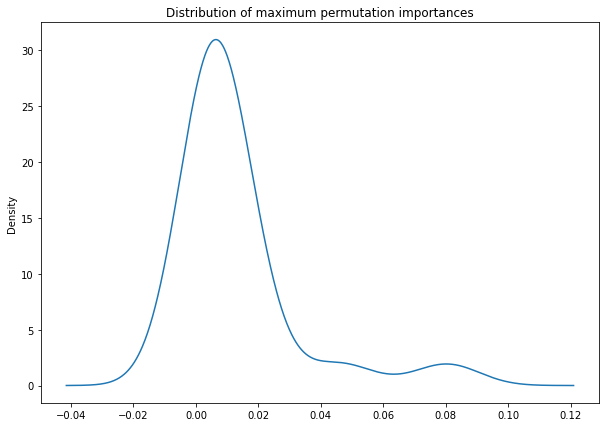

In [144]:
perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances")

The permutation analysis suggests that **none** of the features are important in permuting the prediction. This contradicts the clear separation of the classes in the embedded space. 

It could be that all the features are highly correlated with at least one other feature.

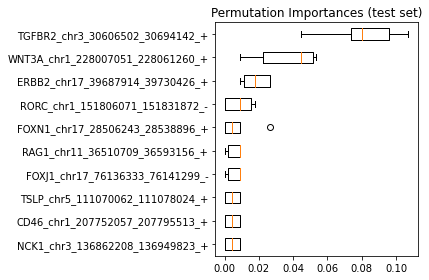

In [145]:
sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]

fig, ax = plt.subplots()
ax.boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(cols)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


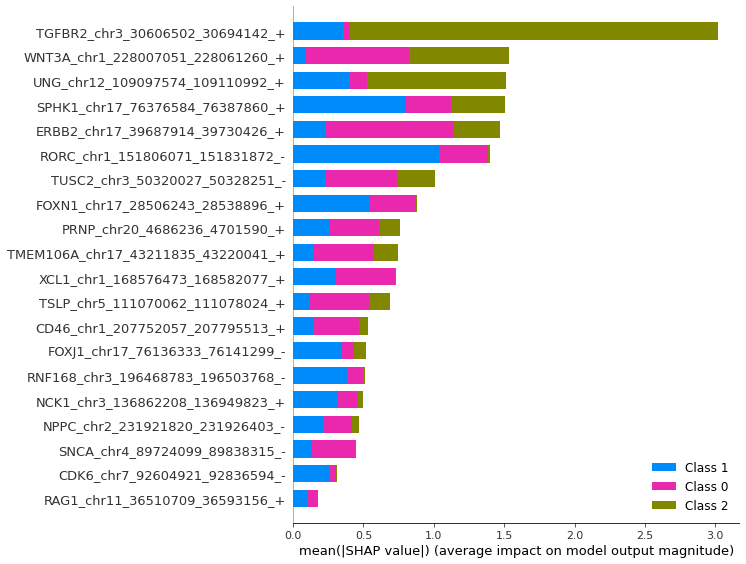

In [146]:
explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, cols)


Text(0.5, 1.0, 'RORC expression')

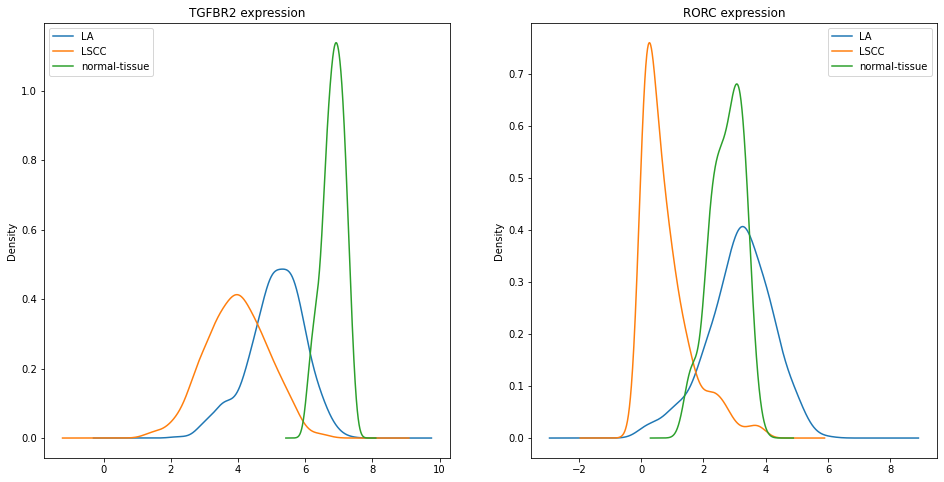

In [167]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
RNAex.loc[RNAex.y=='LA-tumor', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='LA', ax=ax[0])
RNAex.loc[RNAex.y=='LSCC-tumor', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='LSCC', ax=ax[0])
RNAex.loc[RNAex.y=='normal-tissue', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='normal-tissue', ax=ax[0])
ax[0].legend()
ax[0].set_title('TGFBR2 expression')

RNAex.loc[RNAex.y=='LA-tumor', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='LA', ax=ax[1])
RNAex.loc[RNAex.y=='LSCC-tumor', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='LSCC', ax=ax[1])
RNAex.loc[RNAex.y=='normal-tissue', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='normal-tissue', ax=ax[1])
ax[1].legend()
ax[1].set_title('RORC expression')

Accuracies of the models:

In [147]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

Model:RF, Accuracy:0.9735947712418301
Model:XGB, Accuracy:0.9735947712418301
Model:HB, Accuracy:0.9669281045751634
Model:ET, Accuracy:0.9669281045751634
Model:LGBM, Accuracy:0.9735947712418301
Model:LR, Accuracy:0.9735947712418301
Model:SVM, Accuracy:0.9669281045751634


## Combining RNA with Methylation

In [188]:
# RNAex Methylation
probemap.dropna(subset=['Start'], inplace=True)
probemap.Start = probemap.Start.astype(int).astype(str)
probemap.Stop = probemap.Stop.astype(int).astype(str)
probemap['geneid'] = probemap[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
#RNAex.loc[:, rnaID_include]

In [201]:
methylation_new = 1-methylation.loc[:, probemap.probeID].T.dropna()
RNA_new  = RNAex.loc[:, rnaID_include].T

In [230]:
probemap

,probeID,Chr,Start,Stop,Strand,Gene,Relation_CpG_Island,geneid
0,cg00000321,chr8,41310282,41310284,+,RORC,S_Shore,SFRP1_chr8_41310282_41310284_+
1,cg00000884,chr4,153688704,153688706,+,RORC,S_Shelf,TLR2_chr4_153688704_153688706_+
2,cg00002473,chr2,218124152,218124154,+,RORC,None,CXCR2_chr2_218124152_218124154_+
3,cg00005617,chrX,68840054,68840056,+,RORC,N_Shore,EFNB1_chrX_68840054_68840056_+
4,cg00006787,chr13,109881093,109881095,+,RORC,None,IRS2_chr13_109881093_109881095_+
...,...,...,...,...,...,...,...,...
16651,ch.9.1874451R,chr9,118376526,118376527,+,RORC,None,TLR4_chr9_118376526_118376527_+
16652,ch.9.75018133F,chr9,73213396,73213397,-,RORC,None,ANXA1_chr9_73213396_73213397_-
16653,ch.9.914443R,chr9,73755353,73755354,+,RORC,None,ANXA1_chr9_73755353_73755354_+
16654,ch.X.114073068F,chrX,114932248,114932249,-,RORC,None,IL13RA2_chrX_114932248_114932249_-


In [211]:
methylation_new.loc[:, ['TCGA_O2_A5IB_01']]

,TCGA_O2_A5IB_01
probeID,
cg00000321,0.2767
cg00005617,0.5499
cg00006787,0.1256
cg00007221,0.8061
cg00007324,0.0141
...,...
ch.7.3273335R,0.9020
ch.7.3273938R,0.9661
ch.7.42519133R,0.9767


In [212]:
RNA_new.loc[:, ['TCGA_O2_A5IB_01']]

,TCGA_O2_A5IB_01
RORC_chr1_151806071_151831872_-,0.569759
DLG1_chr3_197042560_197299300_-,3.374522
RNF168_chr3_196468783_196503768_-,4.099742
TFRC_chr3_196027183_196082189_-,6.076391
NRARP_chr9_137300482_137302251_-,2.063631
CEACAM6_chr19_41750977_41772208_+,0.475532
EFNB1_chrX_68828997_68842147_+,3.449861
BCL11A_chr2_60451167_60553567_-,2.720966
TSLP_chr5_111070062_111078024_+,1.039520
FOXN1_chr17_28506243_28538896_+,0.032235
